Commençons par les importations et le traitement des données:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
url = 'ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt'
names = ['year', 'month', 'day', 'year_decimal', 'co2', 'days', '1 yr ago', '10 yr ago', 'since 1800']

# 1. Lire le CSV sans définir l'index pour garder toutes les colonnes
df = pd.read_csv(
    url, 
    skiprows=49, 
    header=None, 
    delim_whitespace=True, 
    names=names, 
    na_values=[-999.99]
)

# 2. Créer une colonne 'year_month_day' au format datetime
df['year_month_day'] = pd.to_datetime(df[['year', 'month', 'day']])

# 3. Définir cette colonne comme index
df.set_index('year_month_day', inplace=True)


C:\Users\flavi_d01mztg\AppData\Local\Temp\ipykernel_584\2311705869.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Nettoyons les données

In [4]:
df.fillna(method='ffill', inplace=True)
df = df.drop(columns=['10 yr ago'])
df = df.dropna()

C:\Users\flavi_d01mztg\AppData\Local\Temp\ipykernel_584\2379905393.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [6]:
df.head()

,year,month,day,year_decimal,co2,days,1 yr ago,since 1800
year_month_day,,,,,,,,
1975-05-25,1975,5,25,1975.3959,334.00,7,332.95,51.09
1975-06-01,1975,6,1,1975.4151,333.96,7,332.44,51.18
1975-06-08,1975,6,8,1975.4342,333.19,6,332.20,50.61
1975-06-15,1975,6,15,1975.4534,333.23,7,332.32,50.88
1975-06-22,1975,6,22,1975.4726,333.50,6,331.83,51.45


Model 1 : AR + RF sur Residus   (iterative forecast)

Création des variables Target (y) dividons le dataset en 3 pour entrainement, validation et test. 

In [10]:
y = df['co2']

time = int(len(y) * 0.70)
train, test = y[:time], y[time:]


In [6]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

Analizons l'ACF et le PACF pour decider les Lags du model AR

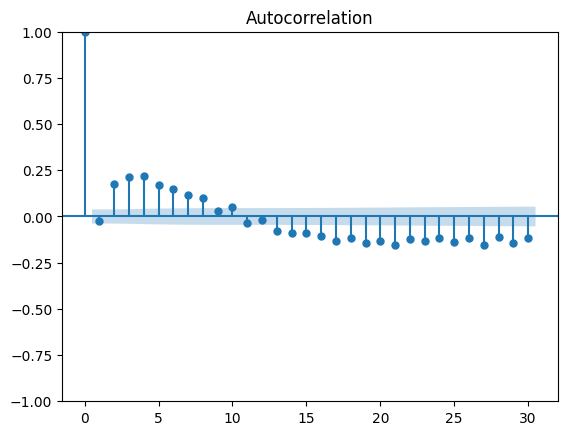

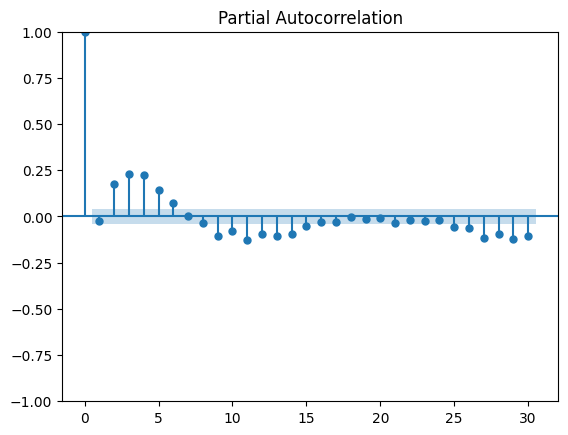

In [7]:
diff = y.diff().dropna()

plot_acf(diff, lags=30)
plot_pacf(diff, lags=30)
plt.show()

Nous pouvons observer deux possibles valeurs pour lags : lags = 6, lags = 14

Evaluons avec le AIC et le BIC 

In [8]:
aic_values = {}
bic_values = {}

for p in range(1, 17):
    try:
        model = sm.tsa.AutoReg(train, lags=p, old_names=False).fit()
        aic_values[p] = int(round(model.aic))
        bic_values[p] = int(round(model.bic))

        print(f"AIC p={p}: {aic_values[p]}")
        print(f"BIC p={p}: {bic_values[p]}")
    except Exception as e:
        print(f"errore per p={p}: {e}")

print("AIC finale :", aic_values)
print("BIC finale :", bic_values)

c:\Users\flavi_d01mztg\Documents\GitHub\Manoaloa\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\flavi_d01mztg\Documents\GitHub\Manoaloa\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\flavi_d01mztg\Documents\GitHub\Manoaloa\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\flavi_d01mztg\Documents\GitHub\Manoaloa\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\flavi_d01mztg\Documents\GitHub\Manoaloa

AIC p=1: 2922
BIC p=1: 2939
AIC p=2: 2922
BIC p=2: 2944
AIC p=3: 2854
BIC p=3: 2882
AIC p=4: 2762
BIC p=4: 2795
AIC p=5: 2665
BIC p=5: 2703
AIC p=6: 2623
BIC p=6: 2667
AIC p=7: 2614
BIC p=7: 2664
AIC p=8: 2615
BIC p=8: 2670
AIC p=9: 2613
BIC p=9: 2674
AIC p=10: 2590
BIC p=10: 2656
AIC p=11: 2584
BIC p=11: 2655
AIC p=12: 2557
BIC p=12: 2634
AIC p=13: 2533
BIC p=13: 2615
AIC p=14: 2509
BIC p=14: 2597
AIC p=15: 2490
BIC p=15: 2583
AIC p=16: 2488
BIC p=16: 2587
AIC finale : {1: 2922, 2: 2922, 3: 2854, 4: 2762, 5: 2665, 6: 2623, 7: 2614, 8: 2615, 9: 2613, 10: 2590, 11: 2584, 12: 2557, 13: 2533, 14: 2509, 15: 2490, 16: 2488}
BIC finale : {1: 2939, 2: 2944, 3: 2882, 4: 2795, 5: 2703, 6: 2667, 7: 2664, 8: 2670, 9: 2674, 10: 2656, 11: 2655, 12: 2634, 13: 2615, 14: 2597, 15: 2583, 16: 2587}


c:\Users\flavi_d01mztg\Documents\GitHub\Manoaloa\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\flavi_d01mztg\Documents\GitHub\Manoaloa\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\flavi_d01mztg\Documents\GitHub\Manoaloa\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\flavi_d01mztg\Documents\GitHub\Manoaloa\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


lag 6 = 17737 / 1779   

lag 14 = 1665 / 1747

AIC et BIC sont plus similaires pour le leg 6, cela peut indiquer un bon équilibrage du model, mais pour le lag 14 nous avons des valeurs plus interessantes. Si on prend en compte le type de données et le fait que le manoaloa a une saisonalité récurrante, l'option de choisir le lag 14 est solont moi plus adaptée.

Commençons par entrainer le model AR

In [11]:
start_v = len(train)
end_v = len(train) + len(test) - 1

start_t = 0
end_t = len(train)  - 1

In [12]:
ar = AutoReg(train, lags=14, seasonal=True)  
res = ar.fit()


predictions_v = res.predict(
    start=start_v,
    end=end_v
)

predictions_t = res.predict(
    start=start_t,
    end=end_t
)

c:\Users\flavi_d01mztg\Documents\GitHub\Manoaloa\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\flavi_d01mztg\Documents\GitHub\Manoaloa\venv\Lib\site-packages\statsmodels\tsa\deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
c:\Users\flavi_d01mztg\Documents\GitHub\Manoaloa\venv\Lib\site-packages\statsmodels\tsa\deterministic.py:441: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_i

Visualisation du model AR

Mae val 5.5413856834779756
RMSE val 6.4876597765865025


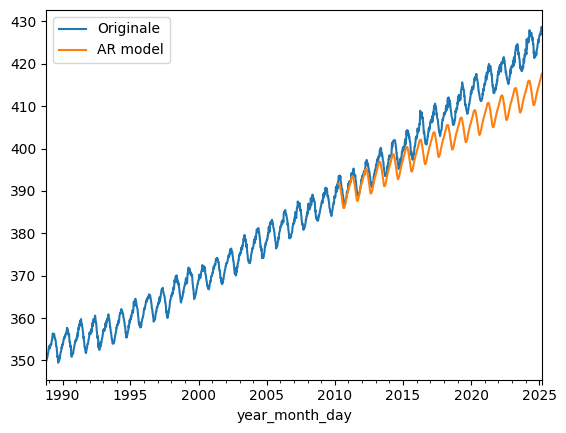

In [13]:
mae_at = mean_absolute_error(test, predictions_v)
rmse_at = np.sqrt(mean_squared_error(test, predictions_v))

print(f"Mae val {mae_at}")
print(f"RMSE val {rmse_at}")

y[700:].plot(label="Originale")
predictions_v.plot(label='AR model')
plt.legend()

Creons les residus pour entrainer le RF et verifions les residus

In [16]:
residus_t = train - predictions_t
residus_v = test - predictions_v


In [28]:
residus_t.isnull().sum()
residus_t.head(15)

year_month_day
1975-08-31    0.619864
1975-09-07    0.856586
1975-09-14   -0.459773
1975-09-21    0.242095
1975-09-28    0.212966
1975-10-05    0.441874
1975-10-12    0.581715
1975-10-19    0.714527
1975-10-26    0.285440
1975-11-02    0.205139
1975-11-09   -0.110361
1975-11-16   -0.105144
1975-11-23    0.636417
1975-11-30   -0.463548
1975-12-07   -0.523098
dtype: float64

In [27]:
residus_t = residus_t[14:]

<Axes: xlabel='year_month_day'>

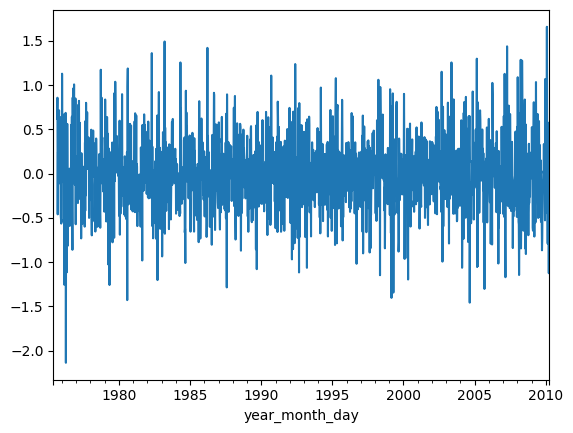

In [17]:
residus_t.plot()

Creons les données pour entrainer le RF

In [18]:
X = y.index.to_series().apply(lambda x: x.toordinal())
X = pd.DataFrame(X)

X['month'] = df['month']
X['1 yr ago'] = df['1 yr ago']

period = 365
n_harmonics = 2

for k in range(1, n_harmonics+1):
    X[f'sin_{k}'] = np.sin(2 * np.pi * k * X['year_month_day'] / period)
    X[f'cos_{k}'] = np.cos(2 * np.pi * k * X['year_month_day'] / period)


z = int(len(X) * 0.70)
X_train, X_test = X[:z], X[z:]

Features (X)

In [29]:
X_train = X_train[14:]

Target (y)

In [30]:
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), [1])],
    remainder='passthrough'
)

rf_model = make_pipeline(preprocessor,
                        RandomForestRegressor(n_estimators=100, random_state=13))
rf_model.fit(X_train, residus_t)

pred_residui = rf_model.predict(X_test)

Plot Residui

<Axes: xlabel='year_month_day'>

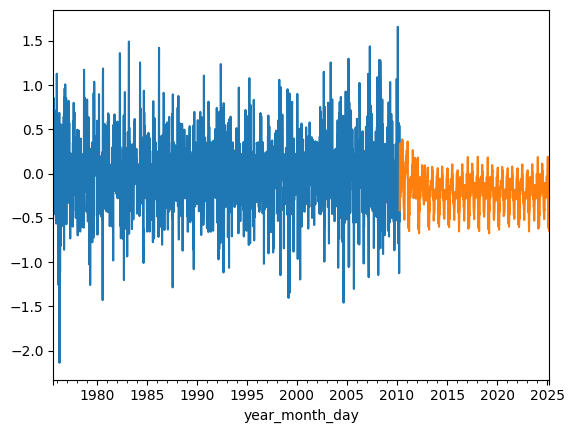

In [31]:
residui = pd.Series(pred_residui, index= X_test.index)

residus_t.plot()
residui.plot()

Plot finale e Valutazioni

In [32]:
final_pred = predictions_v + residui

MAE AR: 5.5413856834779756
MAE Ensamble: 5.739535932602971


RMSE AR: 6.4876597765865025
RMSE Ensamble: 6.658588016449989


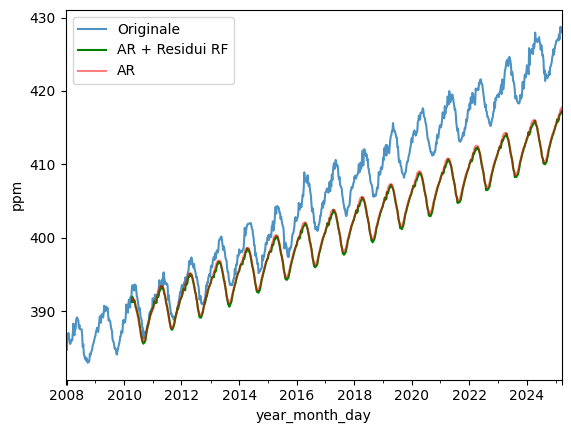

In [33]:
mae_ar = mean_absolute_error(test, predictions_v)
mae_ensamble = mean_absolute_error(test, final_pred)


rmse_ar = np.sqrt(mean_squared_error(test, predictions_v))
rmse_ensamble = np.sqrt(mean_squared_error(test, final_pred))


print("MAE AR:", mae_ar)
print("MAE Ensamble:", mae_ensamble)
print("\n")
print("RMSE AR:", rmse_ar)
print("RMSE Ensamble:", rmse_ensamble)

y[1700:].plot(label='Originale', alpha=.8)

final_pred.plot(label='AR + Residui RF', color='green')
predictions_v.plot(label = 'AR', color='red', alpha=.5)
plt.ylabel('ppm')
plt.legend()


Comme nous pouvons le voir avec nos resultats de MAE et RMSE, la création de ce model hybride n'apporte pas grand chose au model AR de base, En faite le Model AR de base est meuilleur que notre Ensamble de models

Modello 2 : (ES + LR) -> Meta model (LR)

Pour ce deuxieme model, j'ai décidé d'entrainer deux models en paralleles puis entrainer un troisiem model (méta model) pour eviter de faire une simple addition

Préparons les données

In [426]:
y = df['co2']

time = int(len(y) * 0.50)
train, y_2 = y[:time], y[time:]

time_2 = int(len(y_2) * 0.50)
val, test = y_2[:time_2], y_2[time_2:]

In [463]:
X = y.index.to_series().apply(lambda x: x.toordinal())
X = pd.DataFrame(X)

X['month'] = df['month']
#X['1 yr ago'] = df['1 yr ago']
#X['days'] = df['days']

z = int(len(X) * 0.50)
X_train, x2 = X[:z], X[z:]

z_2 = int(len(x2) * 0.50)
X_val, X_test = x2[:z_2], x2[z_2:]

In [73]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Créons le model ES

In [464]:
model_em = ExponentialSmoothing(
    train, 
    trend="mul",    
    seasonal="add", 
    damped_trend=False,
    seasonal_periods=52, 
    initialization_method="estimated"
)


model_fit = model_em.fit(optimized=True, use_brute=True, remove_bias=False)

##########
num_step = len(val) 
es_pred_v = model_fit.forecast(steps=num_step)

num_steps = len(val) +len(test) 
es_pred_all = model_fit.forecast(steps=num_steps)


c:\Users\flavi_d01mztg\Documents\GitHub\Forecasting_Sticker_Sales\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\flavi_d01mztg\Documents\GitHub\Forecasting_Sticker_Sales\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [465]:
es_pred_t = es_pred_all.loc[~es_pred_all.index.isin(es_pred_v.index)]

Créons un deuxieme model pour pouvoir comparer notre méta model

In [466]:
model_em2 = ExponentialSmoothing(
    val, 
    trend="mul",    
    seasonal="add", 
    damped_trend=False,
    seasonal_periods=52, 
    initialization_method="estimated"
)


model_fit2 = model_em2.fit(optimized=True, use_brute=True, remove_bias=False)

##########
num_step2 = len(test) 
es_pred_vt = model_fit2.forecast(steps=num_step2)


c:\Users\flavi_d01mztg\Documents\GitHub\Forecasting_Sticker_Sales\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\flavi_d01mztg\Documents\GitHub\Forecasting_Sticker_Sales\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Plot e Visualisations

MAE 2.4079739676713685
RMSE 2.8789189105394644


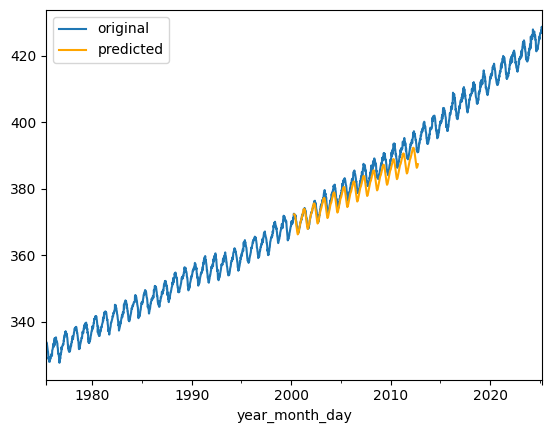

In [467]:
mae_es = mean_absolute_error(val, es_pred_v)
rmse_es = np.sqrt(mean_squared_error(val, es_pred_v))

print(f'MAE {mae_es}')
print(f'RMSE {rmse_es}')

y.plot(label='original')
es_pred_v.plot(label='predicted', color='orange')
plt.legend()

Features (X), noter que dans la pipeline nous appliquons un OneHOT pour les mois ainsi que des Features Polynomiales

In [476]:
X_train.head()

,year_month_day,month
year_month_day,,
1975-05-25,721133,5
1975-06-01,721140,6
1975-06-08,721147,6
1975-06-15,721154,6
1975-06-22,721161,6


Target (y)

In [528]:
train.head()

year_month_day
1975-05-25    334.00
1975-06-01    333.96
1975-06-08    333.19
1975-06-15    333.23
1975-06-22    333.50
Name: co2, dtype: float64

Créons le model AR

In [477]:
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), [1])],
    remainder='passthrough'  
)

model_lr = make_pipeline(preprocessor,
                           PolynomialFeatures(2),
                           LinearRegression())
model_lr.fit(X_train, train)

pred_lr_v = model_lr.predict(X_val)
pred_lr_t = model_lr.predict(X_test)

y_pred_lr_v = pd.Series(pred_lr_v, index=val.index)
y_pred_lr_t = pd.Series(pred_lr_t, index=test.index)

Faison la meme chose qu'avant

In [478]:
preprocessor2 = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), [1])],
    remainder='passthrough'  
)

model_lr2 = make_pipeline(preprocessor2,
                           PolynomialFeatures(2),
                           LinearRegression())
model_lr2.fit(X_val, val)

pred_lr_vt = model_lr2.predict(X_test)

y_pred_lr_vt = pd.Series(pred_lr_vt, index=test.index)

Valutation du model AR

MAE 3.634821178376471
RMSE 4.13408289738381


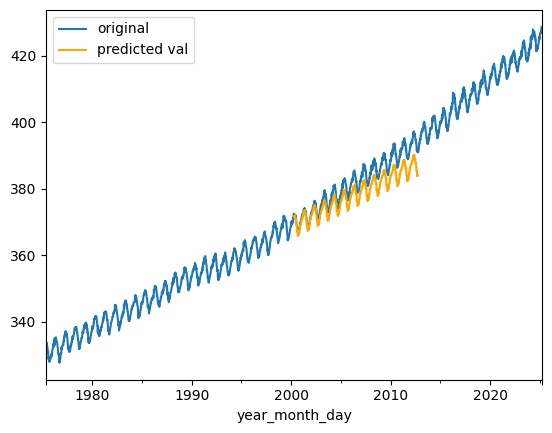

In [480]:
mae_lr = mean_absolute_error(val, y_pred_lr_v)
rmse_lr = np.sqrt(mean_squared_error(val, y_pred_lr_v))

print(f'MAE {mae_lr}')
print(f'RMSE {rmse_lr}')

y.plot(label='original')
y_pred_lr_v.plot(label='predicted val', color='orange')
plt.legend()

Réorganisons les données pour le Méta model

In [472]:
es_pred_v.name = 'AR'
y_pred_lr_v.name = 'LR'

meta_X_train = pd.DataFrame(es_pred_v)
meta_X_train['LR'] = y_pred_lr_v

meta_y_train = val

es_pred_t.name = 'AR'
y_pred_lr_t.name = 'LR'

meta_X_test = pd.DataFrame(es_pred_t)
meta_X_test['LR'] = y_pred_lr_t

meta_y_test = test

Création et prédictions du méta model

In [473]:
meta_model = LinearRegression()

meta_model.fit(meta_X_train, meta_y_train)

meta_pred = meta_model.predict(meta_X_test)

In [474]:
y_pred_ensemble = pd.Series(meta_pred, index=meta_X_test.index)

Plot et visualisation du model

MAE LR 4.338341673813073
RMSE LR 5.050748861115449


MAE ENSAMBLE 3.498143598178062
RMSE ENSAMBLE 4.040881123940047


MAE ES 1.8872074546265032
RMSE ES 2.271161159675961


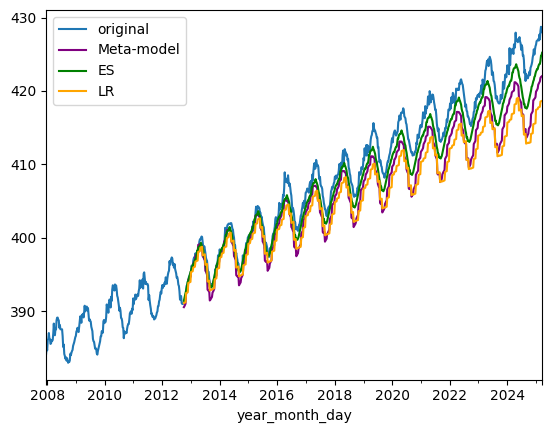

In [484]:
mae_lr_vt = mean_absolute_error(test, y_pred_lr_vt)
rmse_lr_vt = np.sqrt(mean_squared_error(test, y_pred_lr_vt))

mae_ensamble = mean_absolute_error(test, y_pred_ensemble)
rmse_ensamble = np.sqrt(mean_squared_error(test, y_pred_ensemble))

mae_es_vt = mean_absolute_error(test, es_pred_vt)
rmse_es_vt = np.sqrt(mean_squared_error(test, es_pred_vt))

print(f'MAE LR {mae_lr_vt}')
print(f'RMSE LR {rmse_lr_vt}')
print(f"\n")
print(f'MAE ENSAMBLE {mae_ensamble}')
print(f'RMSE ENSAMBLE {rmse_ensamble}')
print(f'\n')
print(f'MAE ES {mae_es_vt}')
print(f'RMSE ES {rmse_es_vt}')


y[1700:].plot(label='original')
y_pred_ensemble.plot(label='Meta-model', color='purple')
es_pred_vt.plot(label='ES', color='green')
y_pred_lr_vt.plot(label='LR', color='orange')
plt.legend()

Avec l'utilisation d'un meta modeln nous pouvons mieux gérér la balance des prédictions d'un model plutôt qu'une simple moyenne. Le métamodel rend la prévision plus robuste.

Modello 3: Prophet + light gbm  (rolling window)

Ici on essayera d'entrainer un lgbm sur les previsions d'un prophet pour voir si c'est une bonne idée ou pas

Géstion des données

In [501]:
from prophet import Prophet

In [503]:
df_prophet = df[['co2']].reset_index().rename(columns={'year_month_day': 'ds', 'co2': 'y'}).dropna()

time_p = int(len(df_prophet) * 0.50)
train, x2 = df_prophet[:time_p], df_prophet[time_p:]

time_p2 = int(len(x2) * 0.50)
val, test = x2[:time_p2], x2[time_p2:]

In [502]:
train.head()

year_month_day
1975-05-25    334.00
1975-06-01    333.96
1975-06-08    333.19
1975-06-15    333.23
1975-06-22    333.50
Name: co2, dtype: float64

Créons le model prophet et faisons les predictions

In [504]:
model_prophet = Prophet(
    yearly_seasonality=True,  
    weekly_seasonality=False,
    daily_seasonality=False,  
)
model_prophet.fit(train)

21:07:20 - cmdstanpy - INFO - Chain [1] start processing
21:07:21 - cmdstanpy - INFO - Chain [1] done processing


In [505]:
forecast_val = model_prophet.predict(val) 
forecast_test = model_prophet.predict(test) 

Recuperons uniquements les données qui nous interessent

In [506]:
forecast_val = forecast_val[['trend', 'yhat']]
forecast_val.index = val['ds']

forecast_test = forecast_test[['trend', 'yhat']]
forecast_test.index = test['ds']

In [507]:
forecast_test.head()

,trend,yhat
ds,,
2012-10-07,393.438012,389.967605
2012-10-14,393.474229,390.201279
2012-10-21,393.510446,390.484759
2012-10-28,393.546663,390.791334
2012-11-04,393.582879,391.111998


Réorganisons les données pour entrainer le lbgm

In [542]:
y = df['co2']

time = int(len(y) * 0.50)
train, x2 = y[:time], y[time:]

time2 = int(len(x2) * 0.50)
val, test = x2[:time2], x2[time2:]

X = y.index.to_series().apply(lambda x: x.toordinal())
X = pd.DataFrame(X)

#X['month'] = df['month']
#X['days'] = df['days']

period = 52
n_harmonics = 2

for k in range(1, n_harmonics+1):
    X[f'sin_{k}'] = np.sin(2 * np.pi * k * X['year_month_day'] / period)
    X[f'cos_{k}'] = np.cos(2 * np.pi * k * X['year_month_day'] / period)


z = int(len(X) * 0.50)
X_train, t2 = X[:z], X[z:]

z2 = int(len(t2) * 0.50)
X_val, X_test = t2[:z2], t2[z2:]

X_val['trend'] = forecast_val['trend']
X_val['yhat'] = forecast_val['yhat']

X_test['trend'] = forecast_test['trend']
X_test['yhat'] = forecast_test['yhat']

C:\Users\flavi_d01mztg\AppData\Local\Temp\ipykernel_26904\198567493.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['trend'] = forecast_val['trend']
C:\Users\flavi_d01mztg\AppData\Local\Temp\ipykernel_26904\198567493.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['yhat'] = forecast_val['yhat']
C:\Users\flavi_d01mztg\AppData\Local\Temp\ipykernel_26904\198567493.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [538]:
X_val = X_val.drop(columns=['trend', 'yhat'])
X_test = X_test.drop(columns=['trend', 'yhat'])

In [543]:
X_val.head()

,year_month_day,sin_1,cos_1,sin_2,cos_2,trend,yhat
year_month_day,,,,,,,
2000-04-23,730233,-0.354605,0.935016,-0.663123,0.748511,369.897074,372.751540
2000-04-30,730240,0.464723,0.885456,0.822984,0.568065,369.933290,372.943202
2000-05-07,730247,0.970942,0.239316,0.464723,-0.885456,369.969507,373.082094
2000-05-14,730254,0.822984,-0.568065,-0.935016,-0.354605,370.005724,373.149562
2000-05-21,730261,0.120537,-0.992709,-0.239316,0.970942,370.041941,373.139565


Entrainons le GBM et faaisons les predictions

In [510]:
from lightgbm import LGBMRegressor

In [544]:
predictions_rolling = []
train_data = X_val.copy()  
train_target = val.copy()  


model = LGBMRegressor(n_estimators=100, learning_rate=0.1)

for t in range(len(X_test)):
    
    model.fit(train_data, train_target)
    
    yhat = model.predict(X_test.iloc[[t]]) 
    predictions_rolling.append(yhat[0])
    
    train_data = pd.concat([train_data, X_test.iloc[[t]]])
    train_target = pd.concat([train_target, pd.Series([test.iloc[t]])])

predictions_rolling = pd.Series(predictions_rolling, index=test.index)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1519
[LightGBM] [Info] Number of data points in the train set: 650, number of used features: 7
[LightGBM] [Info] Start training from score 381.899692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [541]:
senza_prophet = predictions_rolling

MAE  0.758919277234306
RMSE 0.9772364351081008


MAE Senza Prophet 2.28266234291925
RMSE Senza Prophet 2.524852002573995


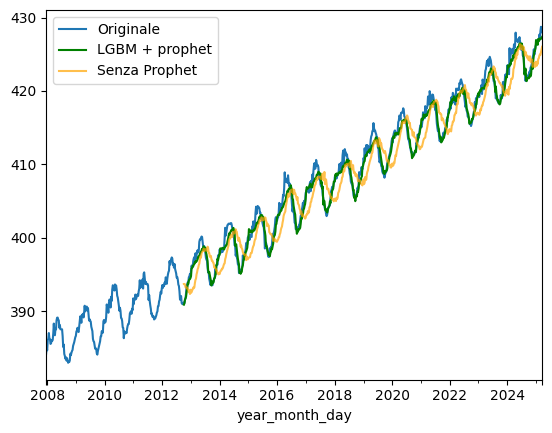

In [548]:
mae_tt = mean_absolute_error(test, predictions_rolling)
rmse_tt = np.sqrt(mean_squared_error(test, predictions_rolling))

mae_ttp = mean_absolute_error(test, senza_prophet)
rmse_ttp = np.sqrt(mean_squared_error(test, senza_prophet))

print(f'MAE  {mae_tt}')
print(f'RMSE {rmse_tt}')
print('\n')
print(f'MAE Senza Prophet {mae_ttp}')
print(f'RMSE Senza Prophet {rmse_ttp}')


y[1700:].plot(label='Originale')
predictions_rolling.plot(label='LGBM + prophet', color='green')
senza_prophet.plot(label='Senza Prophet', alpha=.7, color='orange')
plt.legend()

Comme nous pouvons voir du graphique le Prophet aide beaucoup dans la prediction. On peut noter que le LGBM fonctionne à merveille en utilisant la téchnique du rolling window. Peut etre un model hybride linéaire nous pouvons obtenir des resultats encore meuilleurs!